# Optuna Tuning | Multi-Layer Perceptron
**Multi-Layer Perceptron** hyper-parameter tuning for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

> **[CAUTION]** Do <u>NOT</u> execute "Run All", that will tell Optuna to run hyper-parameter tuning, regardless of whether you have already done it or not. Avoid running the _"Hyper-parameter tuning"_ subsections if you don't have to.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [1]:
# Data Analysis
import numpy as np
import pandas as pd

# Hyperparameter optimization
import optuna

# Machine learning
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import Counter

from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, fbeta_score, make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPClassifier

### 0.2 Constants

In [ ]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

MODEL_NAME = 'mlp' # Modify this to the model you are using

OPTUNA_PATH = '../optuna/'
OPTUNA_DIR = OPTUNA_PATH + MODEL_NAME + '/'

STUDY_NAME = "Diabetes_130-US"
STUDY_PATH_NONE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_none.log"
STUDY_PATH_RUS = OPTUNA_DIR + f"optuna_{MODEL_NAME}_rus.log"
STUDY_PATH_SMOTE = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote.log"
STUDY_PATH_SMOTE_TOMEK = OPTUNA_DIR + f"optuna_{MODEL_NAME}_smote-tomek.log"

# Ensure the directories exist
os.makedirs(OPTUNA_DIR, exist_ok=True)
os.makedirs(os.path.dirname(STUDY_PATH_NONE), exist_ok=True)

N_TRIALS = 100
RANDOM_STATE = 38

SCORE_NAME = 'F1-Score'
SCORING = make_scorer(fbeta_score, beta=1, average='macro')

### 0.3 Loading datasets

In [4]:
train_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'train.csv',
    na_values='?',
    keep_default_na=False
)

test_set = pd.read_csv(
    DATA_PATH_PROCESSED + 'test.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Feature Scaling**
Applying scaling to numerical features.

In [5]:
target = 'readmitted'

X_train = train_set.drop(target, axis=1)
y_train = train_set[target]

X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

### 1.1 Scaling
Applying scaling to numerical features, while leaving boolean features untouched.

In [6]:
NUMERICAL_COLUMNS = [
    'age', 'time_in_hospital', 'num_medications',
    'num_emergency', 'num_inpatient', 'num_diagnoses'
]

In [7]:
scaler = MinMaxScaler()

X_train[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler.transform(X_test[NUMERICAL_COLUMNS])

In [8]:
print('Train set:', Counter(y_train))
print('Test set:', Counter(y_test))

Train set: Counter({0: 45522, 1: 4523})
Test set: Counter({0: 19510, 1: 1938})


## **2. Optuna Hyper-parameter Tuning | No under/oversampling**
Hyper-parameter tuning of the model using Optuna, with no undersampling/oversampling.

### 2.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [11]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "hidden_layer_sizes": tuple(
            trial.suggest_int(f"layer_{i}", 32, 128, step=16) for i in range(trial.suggest_int("n_layers", 1, 2))
        ),
        "activation": trial.suggest_categorical("activation", ["tanh", "relu", "logistic"]),
        "solver": trial.suggest_categorical("solver", ["sgd", "adam"]),
        "alpha": trial.suggest_float("alpha", 1e-5, 1e-2, log=True),
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-3, 1e-1, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64]),
        "early_stopping": False
    }
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    model = MLPClassifier(**params, random_state=RANDOM_STATE)
    
    # Cross validation
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [12]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_NONE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-01-21 18:36:56,199] A new study created in Journal with name: Diabetes_130-US


### 2.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [ ]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

[I 2025-01-21 18:38:51,792] Trial 5 finished with value: 0.47676358189981904 and parameters: {'n_layers': 1, 'layer_0': 48, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00012408648754737593, 'learning_rate_init': 0.048153273597862443, 'batch_size': 64}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47849045 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47676358189981904


[I 2025-01-21 18:39:20,362] Trial 4 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 96, 'activation': 'logistic', 'solver': 'adam', 'alpha': 4.0590974657551935e-05, 'learning_rate_init': 0.04870429028185551, 'batch_size': 64}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:42:03,355] Trial 3 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 32, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0023086765455096405, 'learning_rate_init': 0.006569878582832579, 'batch_size': 32}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:42:05,502] Trial 6 finished with value: 0.47632501324129584 and parameters: {'n_layers': 1, 'layer_0': 128, 'activation': 'tanh', 'solver': 'adam', 'alpha': 2.1682490235077485e-05, 'learning_rate_init': 0.010340043221529812, 'batch_size': 64}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47629761 0.47629761 0.47632501]
Average score: 0.47632501324129584


[I 2025-01-21 18:42:51,538] Trial 1 finished with value: 0.4763304938794345 and parameters: {'n_layers': 1, 'layer_0': 80, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0003286900725144291, 'learning_rate_init': 0.07463236247834511, 'batch_size': 32}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47632501 0.47632501 0.47632501 0.47632501]
Average score: 0.4763304938794345


[I 2025-01-21 18:43:27,991] Trial 10 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'layer_0': 96, 'layer_1': 48, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0012221840611715664, 'learning_rate_init': 0.0033141115803314537, 'batch_size': 64}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:44:47,132] Trial 8 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 96, 'activation': 'relu', 'solver': 'sgd', 'alpha': 7.485463101742192e-05, 'learning_rate_init': 0.012681313201926702, 'batch_size': 32}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:45:08,667] Trial 11 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'layer_0': 96, 'layer_1': 128, 'activation': 'tanh', 'solver': 'adam', 'alpha': 9.340098343504068e-05, 'learning_rate_init': 0.018504428518498373, 'batch_size': 32}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:45:55,401] Trial 15 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 32, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.00022431964560170662, 'learning_rate_init': 0.007489001884868863, 'batch_size': 64}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:46:14,662] Trial 2 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 112, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 8.718925059900107e-05, 'learning_rate_init': 0.018022226323207893, 'batch_size': 32}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:48:10,809] Trial 19 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 96, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.003690924587652854, 'learning_rate_init': 0.006729976404479854, 'batch_size': 64}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:48:51,393] Trial 14 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 128, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0026593629114653266, 'learning_rate_init': 0.01223764336971724, 'batch_size': 32}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:49:21,341] Trial 13 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 96, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 7.73378537382468e-05, 'learning_rate_init': 0.03701811988052057, 'batch_size': 32}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:50:26,511] Trial 18 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'layer_0': 48, 'layer_1': 32, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 7.802436319046003e-05, 'learning_rate_init': 0.040636678830734754, 'batch_size': 64}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:50:34,422] Trial 21 finished with value: 0.476330493306026 and parameters: {'n_layers': 1, 'layer_0': 64, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0005460529379623997, 'learning_rate_init': 0.024365248027000262, 'batch_size': 64}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47629761]
Average score: 0.476330493306026


[I 2025-01-21 18:52:41,517] Trial 24 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 48, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.00018342985826339154, 'learning_rate_init': 0.0260574903752598, 'batch_size': 64}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:52:48,496] Trial 16 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'layer_0': 112, 'layer_1': 64, 'activation': 'logistic', 'solver': 'adam', 'alpha': 2.9028152807571196e-05, 'learning_rate_init': 0.05654006342118215, 'batch_size': 32}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:53:06,810] Trial 22 finished with value: 0.476330493306026 and parameters: {'n_layers': 1, 'layer_0': 64, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0005866133069410496, 'learning_rate_init': 0.09602823468549379, 'batch_size': 32}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47629761]
Average score: 0.476330493306026


[I 2025-01-21 18:53:27,136] Trial 26 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 64, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0008644728144380873, 'learning_rate_init': 0.016679969081590675, 'batch_size': 64}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:54:57,273] Trial 7 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'layer_0': 112, 'layer_1': 64, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.004867998544760157, 'learning_rate_init': 0.005566674040142911, 'batch_size': 32}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:55:39,708] Trial 0 finished with value: 0.47653357838907 and parameters: {'n_layers': 2, 'layer_0': 64, 'layer_1': 128, 'activation': 'tanh', 'solver': 'adam', 'alpha': 7.526138495522203e-05, 'learning_rate_init': 0.0010338004093813787, 'batch_size': 64}. Best is trial 5 with value: 0.47676358189981904.


Cross validation scores: [0.47635241 0.47632501 0.47736784 0.47629761 0.47632501]
Average score: 0.47653357838907


[I 2025-01-21 18:56:08,262] Trial 28 finished with value: 0.47890633978023106 and parameters: {'n_layers': 1, 'layer_0': 80, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00029122437027457096, 'learning_rate_init': 0.03279313621120845, 'batch_size': 64}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.48920424 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47890633978023106


[I 2025-01-21 18:56:12,318] Trial 30 finished with value: 0.4783848957453582 and parameters: {'n_layers': 1, 'layer_0': 80, 'activation': 'tanh', 'solver': 'adam', 'alpha': 4.45255465986445e-05, 'learning_rate_init': 0.09066079205109584, 'batch_size': 64}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.48254275 0.48040668 0.47632501 0.47632501 0.47632501]
Average score: 0.4783848957453582


[I 2025-01-21 18:56:19,161] Trial 17 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'layer_0': 48, 'layer_1': 80, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.00016859836875636428, 'learning_rate_init': 0.011101493536291428, 'batch_size': 32}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:56:46,513] Trial 23 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 80, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 1.12475322786954e-05, 'learning_rate_init': 0.020786909052442726, 'batch_size': 32}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:57:48,585] Trial 27 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 48, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.00013980605029722152, 'learning_rate_init': 0.06291787949960964, 'batch_size': 32}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:57:55,319] Trial 34 finished with value: 0.47655622899613287 and parameters: {'n_layers': 1, 'layer_0': 80, 'activation': 'tanh', 'solver': 'adam', 'alpha': 4.73074728800192e-05, 'learning_rate_init': 0.07500343363843827, 'batch_size': 64}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47635241 0.47745369 0.47632501 0.47632501 0.47632501]
Average score: 0.47655622899613287


[I 2025-01-21 18:58:02,017] Trial 35 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 64, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0002867328847392278, 'learning_rate_init': 0.09713332641140943, 'batch_size': 64}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:59:07,689] Trial 36 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 80, 'activation': 'tanh', 'solver': 'adam', 'alpha': 5.197543195156319e-05, 'learning_rate_init': 0.0503498615862542, 'batch_size': 64}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 18:59:19,697] Trial 37 finished with value: 0.4765505055200817 and parameters: {'n_layers': 1, 'layer_0': 48, 'activation': 'tanh', 'solver': 'adam', 'alpha': 3.2413385463371836e-05, 'learning_rate_init': 0.0719868552862754, 'batch_size': 64}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47742507 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.4765505055200817


[I 2025-01-21 18:59:55,338] Trial 31 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 32, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0013732344393567815, 'learning_rate_init': 0.0025393507932561813, 'batch_size': 32}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 19:00:47,283] Trial 40 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 64, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00013003108322098622, 'learning_rate_init': 0.0806885492792747, 'batch_size': 64}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 19:00:56,291] Trial 33 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'layer_0': 80, 'layer_1': 112, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00013800804390142613, 'learning_rate_init': 0.031075310751966873, 'batch_size': 64}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 19:01:09,039] Trial 38 finished with value: 0.4763030843780972 and parameters: {'n_layers': 1, 'layer_0': 80, 'activation': 'tanh', 'solver': 'adam', 'alpha': 1.9579678118290287e-05, 'learning_rate_init': 0.04331073022939423, 'batch_size': 64}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47635241 0.47635241 0.47616057 0.47632501 0.47632501]
Average score: 0.4763030843780972


[I 2025-01-21 19:01:09,789] Trial 39 finished with value: 0.4763250138147043 and parameters: {'n_layers': 1, 'layer_0': 64, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0004125635654868816, 'learning_rate_init': 0.03010631349696384, 'batch_size': 64}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47635241 0.47629761 0.47632501 0.47632501 0.47632501]
Average score: 0.4763250138147043


[I 2025-01-21 19:01:13,119] Trial 29 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 112, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.00044308691589286614, 'learning_rate_init': 0.014784147730850883, 'batch_size': 32}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 19:01:40,593] Trial 42 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 80, 'activation': 'tanh', 'solver': 'adam', 'alpha': 5.619511687408049e-05, 'learning_rate_init': 0.07481020801927679, 'batch_size': 64}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 19:02:41,699] Trial 44 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 80, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00011090913881287494, 'learning_rate_init': 0.08788951245295702, 'batch_size': 64}. Best is trial 28 with value: 0.47890633978023106.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 19:03:17,781] Trial 45 finished with value: 0.48701990921059907 and parameters: {'n_layers': 1, 'layer_0': 96, 'activation': 'tanh', 'solver': 'adam', 'alpha': 5.018044551199522e-05, 'learning_rate_init': 0.06600401664725031, 'batch_size': 64}. Best is trial 45 with value: 0.48701990921059907.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47618798 0.52988172]
Average score: 0.48701990921059907


[I 2025-01-21 19:03:20,419] Trial 46 finished with value: 0.4762976008710254 and parameters: {'n_layers': 1, 'layer_0': 112, 'activation': 'tanh', 'solver': 'adam', 'alpha': 5.9663283739064777e-05, 'learning_rate_init': 0.04900816992904434, 'batch_size': 64}. Best is trial 45 with value: 0.48701990921059907.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47613315]
Average score: 0.4762976008710254


[I 2025-01-21 19:03:43,937] Trial 9 finished with value: 0.47633597337075617 and parameters: {'n_layers': 2, 'layer_0': 112, 'layer_1': 128, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.008250712940607806, 'learning_rate_init': 0.03518291460331883, 'batch_size': 64}. Best is trial 45 with value: 0.48701990921059907.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 19:03:52,638] Trial 43 finished with value: 0.4771275485550966 and parameters: {'n_layers': 1, 'layer_0': 96, 'activation': 'tanh', 'solver': 'adam', 'alpha': 2.1369923203124406e-05, 'learning_rate_init': 0.0447810379932541, 'batch_size': 64}. Best is trial 45 with value: 0.48701990921059907.


Cross validation scores: [0.47635241 0.47632501 0.47632501 0.48031029 0.47632501]
Average score: 0.4771275485550966


[I 2025-01-21 19:04:30,259] Trial 41 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 96, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0002444161584459489, 'learning_rate_init': 0.0587713711468695, 'batch_size': 64}. Best is trial 45 with value: 0.48701990921059907.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 19:04:36,080] Trial 47 finished with value: 0.47633597337075617 and parameters: {'n_layers': 1, 'layer_0': 80, 'activation': 'tanh', 'solver': 'adam', 'alpha': 2.857133053588213e-05, 'learning_rate_init': 0.034340839806446075, 'batch_size': 64}. Best is trial 45 with value: 0.48701990921059907.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47632501 0.47632501]
Average score: 0.47633597337075617


[I 2025-01-21 19:05:14,502] Trial 52 finished with value: 0.4893496506972209 and parameters: {'n_layers': 1, 'layer_0': 96, 'activation': 'tanh', 'solver': 'adam', 'alpha': 4.751348587305788e-05, 'learning_rate_init': 0.07152387532108881, 'batch_size': 64}. Best is trial 52 with value: 0.4893496506972209.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47843081 0.5392876 ]
Average score: 0.4893496506972209


[I 2025-01-21 19:05:17,638] Trial 48 finished with value: 0.476330493306026 and parameters: {'n_layers': 1, 'layer_0': 64, 'activation': 'relu', 'solver': 'adam', 'alpha': 4.1123290764553886e-05, 'learning_rate_init': 0.02348297938221436, 'batch_size': 64}. Best is trial 52 with value: 0.4893496506972209.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.47629761 0.47632501]
Average score: 0.476330493306026


[I 2025-01-21 19:05:19,000] Trial 49 finished with value: 0.47656195243661104 and parameters: {'n_layers': 1, 'layer_0': 48, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001885298935145004, 'learning_rate_init': 0.008301838029779032, 'batch_size': 64}. Best is trial 52 with value: 0.4893496506972209.


Cross validation scores: [0.47635241 0.47748231 0.47632501 0.47632501 0.47632501]
Average score: 0.47656195243661104


[I 2025-01-21 19:05:50,186] Trial 53 finished with value: 0.47775174179469104 and parameters: {'n_layers': 1, 'layer_0': 112, 'activation': 'tanh', 'solver': 'adam', 'alpha': 1.8476794761017723e-05, 'learning_rate_init': 0.04810549001571876, 'batch_size': 64}. Best is trial 52 with value: 0.4893496506972209.


Cross validation scores: [0.47635241 0.47635241 0.47632501 0.4835683  0.47616057]
Average score: 0.47775174179469104


In [14]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 47
Best Parameters: {'n_layers': 1, 'layer_0': 64, 'activation': 'tanh', 'solver': 'adam', 'alpha': 5.033077685822647e-05, 'learning_rate_init': 0.07661854892933045, 'batch_size': 32}
Best Value: 0.5226678917952157


### 2.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [15]:
optuna.visualization.plot_optimization_history(study)

In [16]:
optuna.visualization.plot_slice(study)

In [17]:
optuna.visualization.plot_param_importances(study)

In [18]:
optuna.visualization.plot_parallel_coordinate(study)

In [19]:
optuna.visualization.plot_contour(study)

In [20]:
optuna.visualization.plot_timeline(study)

### 2.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [ ]:
# Fit best model on the training set
best_params = study.best_params

# Get hidden layer sizes
hidden_layer_sizes = tuple(
    best_params[f"layer_{i}"] for i in range(best_params["n_layers"])
)

# Remove hidden layer sizes from best_params
best_params = {key: val for key, val in best_params.items() if not key.startswith(("layer_", "n_layers"))}

model = MLPClassifier(**best_params, max_iter=200, early_stopping=True, random_state=RANDOM_STATE)

model.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=5.033077685822647e-05, batch_size=32,
              early_stopping=True, learning_rate_init=0.07661854892933045,
              random_state=38)

In [22]:
# Predictions
y_train_pred_none = model.predict(X_train)
y_test_pred_none = model.predict(X_test)

In [23]:
ac_train_none = accuracy_score(y_train, y_train_pred_none)
ac_test_none = accuracy_score(y_test, y_test_pred_none)

print('Train accuracy: ', ac_train_none)
print('Test accuracy: ', ac_test_none)

Train accuracy:  0.909621340793286
Test accuracy:  0.9096419246549795


In [24]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_none,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.91      1.00      0.95     19510
      Early-readmission       0.00      0.00      0.00      1938

               accuracy                           0.91     21448
              macro avg       0.45      0.50      0.48     21448
           weighted avg       0.83      0.91      0.87     21448



/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [25]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_none = recall_score(y_test, y_test_pred_none, average='macro')
precision_none = precision_score(y_test, y_test_pred_none, average='macro')
f1_none = f1_score(y_test, y_test_pred_none, average='macro')
roc_auc_none = roc_auc_score(y_test, y_test_pred_none, average='macro')
accuracy_none = accuracy_score(y_test, y_test_pred_none)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<Axes: >

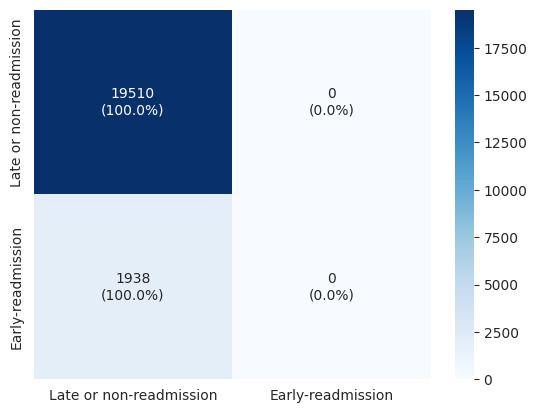

In [26]:
# Visualize confusion matrix with both absolute and percentage values
cm_none = confusion_matrix(y_test, y_test_pred_none)
cm_none_norm = confusion_matrix(y_test, y_test_pred_none, normalize='true')

annotations_none = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_none, cm_none_norm)
])

sns.heatmap(
    cm_none,
    annot=annotations_none,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **3. Optuna Hyper-parameter Tuning | Undersampling**
Hyper-parameter tuning of the model using Optuna, and undersampling with RandomUnderSampler.

### 3.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [27]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "hidden_layer_sizes": tuple(
            trial.suggest_int(f"layer_{i}", 32, 128, step=16) for i in range(trial.suggest_int("n_layers", 1, 3))
        ),
        "activation": trial.suggest_categorical("activation", ["tanh", "relu", "logistic"]),
        "solver": trial.suggest_categorical("solver", ["sgd", "adam"]),
        "alpha": trial.suggest_float("alpha", 1e-5, 1e-2, log=True),
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-3, 1e-1, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64]),
        "early_stopping": False,
        "max_iter": 15
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        RandomUnderSampler(random_state=RANDOM_STATE),
        MLPClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [28]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_RUS))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning:

Argument ``constant_liar`` is an experimental feature. The interface can change in the future.

[I 2025-01-21 18:12:32,565] A new study created in Journal with name: Diabetes_130-US


### 3.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [ ]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-lea

Cross validation scores: [0.48933388 0.49975223 0.51291099 0.48519313 0.49451622]
Average score: 0.4963412889552868


[I 2025-01-21 18:13:34,274] Trial 6 finished with value: 0.4963412889552868 and parameters: {'n_layers': 1, 'layer_0': 112, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.0004118377029509022, 'learning_rate_init': 0.052886818272552524, 'batch_size': 64}. Best is trial 6 with value: 0.4963412889552868.
/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarnin

Cross validation scores: [0.49687454 0.49454108 0.50351977 0.49476792 0.49172294]
Average score: 0.4962852516639926


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-p

Cross validation scores: [0.46758045 0.51748827 0.53916116 0.51790117 0.50567441]
Average score: 0.5095610899941931


[I 2025-01-21 18:15:50,068] Trial 7 finished with value: 0.5093312782396262 and parameters: {'n_layers': 1, 'layer_0': 128, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.0016792768599874334, 'learning_rate_init': 0.026917244653078543, 'batch_size': 64}. Best is trial 3 with value: 0.5095610899941931.


Cross validation scores: [0.50713443 0.51090167 0.51745852 0.51200674 0.49915504]
Average score: 0.5093312782396262


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



Cross validation scores: [0.50420625 0.50769357 0.5127325  0.5046915  0.49276464]
Average score: 0.5044176903341103


[I 2025-01-21 18:16:10,795] Trial 14 finished with value: 0.5044176903341103 and parameters: {'n_layers': 1, 'layer_0': 48, 'activation': 'logistic', 'solver': 'adam', 'alpha': 8.33391074799092e-05, 'learning_rate_init': 0.004361405264815408, 'batch_size': 64}. Best is trial 3 with value: 0.5095610899941931.
/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

[I 2025-01-21 18:16:13,586] Trial 2 finished with value: 0.49985782032950626 and parameters: {'n_layers': 2, 'layer_0': 64, 'layer_1': 128, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.00017108726157691835, 'learning_rate_init': 0.029824799734168142, 'batch_size': 32}. Best is trial 3 with value: 0.5095610899941931.


Cross validation scores: [0.49635258 0.50258919 0.49889913 0.51485261 0.48659559]
Average score: 0.49985782032950626


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.



Cross validation scores: [0.52593088 0.51768974 0.34483979 0.53020841 0.51442747]
Average score: 0.48661925938846


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

[I 2025-01-21 18:16:22,685] Trial 4 finished with value: 0.48661925938846 and parameters: {'n_layers': 3, 'layer_0': 80, 'layer_1': 48, 'layer_2': 80, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0010954775500626767, 'learning_rate_init': 0.07119768907489325, 'batch_size': 32}. Best is trial 3 with value: 0.5095610899941931.
[I 2025-01-21 18:16:23,192] Trial 10 finished with value: 0.5006154388085636 and parameters: {'n_layers': 1, 'layer_0': 64, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.0014634481596697301, 'learning_rate_init': 0.05705458042707708, 'batch_size': 32}. Best is trial 3 with

Cross validation scores: [0.49342861 0.50318699 0.50766649 0.50033355 0.49846156]
Average score: 0.5006154388085636


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

[I 2025-01-21 18:16:29,875] Trial 8 finished with value: 0.4950084765578374 and parameters: {'n_layers': 1, 'layer_0': 128, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.006646435781870866, 'learning_rate_init': 0.02067293379205679, 'batch_size': 64}. Best is trial 3 with value: 0.5095610899941931.


Cross validation scores: [0.48330041 0.48617621 0.50854797 0.5034738  0.49354399]
Average score: 0.4950084765578374


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-p

Cross validation scores: [0.49143707 0.5130469  0.50753679 0.50332537 0.47325557]
Average score: 0.49772033843804947
Cross validation scores: [0.45215866 0.45976005 0.46045864 0.46194991 0.44886789]
Average score: 0.45663902721481237


[I 2025-01-21 18:17:22,427] Trial 15 finished with value: 0.45663902721481237 and parameters: {'n_layers': 3, 'layer_0': 112, 'layer_1': 128, 'layer_2': 48, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.002286286182743293, 'learning_rate_init': 0.0013323461683206613, 'batch_size': 32}. Best is trial 3 with value: 0.5095610899941931.
/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the numb

Cross validation scores: [0.42389338 0.42404599 0.43215844 0.42438002 0.43066263]
Average score: 0.42702809369490574


[I 2025-01-21 18:18:11,850] Trial 18 finished with value: 0.5075451532233203 and parameters: {'n_layers': 3, 'layer_0': 48, 'layer_1': 32, 'layer_2': 112, 'activation': 'relu', 'solver': 'adam', 'alpha': 5.601706764317349e-05, 'learning_rate_init': 0.026774371084722273, 'batch_size': 32}. Best is trial 3 with value: 0.5095610899941931.


Cross validation scores: [0.54717096 0.52170908 0.47229363 0.48797614 0.50857596]
Average score: 0.5075451532233203


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-p

Cross validation scores: [0.4588202  0.55001076 0.53315372 0.53100004 0.50935578]
Average score: 0.5164680992753959


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP:

Cross validation scores: [0.44303712 0.41659711 0.52969809 0.54404816 0.52245121]
Average score: 0.49116633636603596


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached an

Cross validation scores: [0.48760438 0.48370432 0.52057052 0.52199031 0.46805136]
Average score: 0.4963841768548261


/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



In [13]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

Best Trial: 82
Best Parameters: {'n_layers': 1, 'layer_0': 63, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0010241794428508186, 'learning_rate_init': 0.008723987954450287, 'batch_size': 32}
Best Value: 0.524206577661827


### 3.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [14]:
optuna.visualization.plot_optimization_history(study)

In [15]:
optuna.visualization.plot_slice(study)

In [16]:
optuna.visualization.plot_param_importances(study)

In [17]:
optuna.visualization.plot_parallel_coordinate(study)

In [18]:
optuna.visualization.plot_contour(study)

In [19]:
optuna.visualization.plot_timeline(study)

### 3.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [ ]:
# Fit best model on the training set
best_params = study.best_params

# Get hidden layer sizes
hidden_layer_sizes = tuple(
    best_params[f"layer_{i}"] for i in range(best_params["n_layers"])
)

# Remove hidden layer sizes from best_params
best_params = {key: val for key, val in best_params.items() if not key.startswith(("layer_", "n_layers"))}

pipeline_rus = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    MLPClassifier(**best_params, max_iter=200, early_stopping=True, random_state=RANDOM_STATE)
)

pipeline_rus.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('mlpclassifier',
                 MLPClassifier(activation='logistic',
                               alpha=0.0010241794428508186, batch_size=32,
                               learning_rate_init=0.008723987954450287,
                               random_state=38))])

In [23]:
# Predictions
y_train_pred_rus = pipeline_rus.predict(X_train)
y_test_pred_rus = pipeline_rus.predict(X_test)

In [24]:
ac_train_rus = accuracy_score(y_train, y_train_pred_rus)
ac_test_rus = accuracy_score(y_test, y_test_pred_rus)

print('Train accuracy: ', ac_train_rus)
print('Test accuracy: ', ac_test_rus)

Train accuracy:  0.6190028973923469
Test accuracy:  0.6123647892577396


In [25]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_rus,
    target_names=['Late or non-readmission', 'Early-readmission']
))

                         precision    recall  f1-score   support

Late or non-readmission       0.93      0.62      0.74     19510
      Early-readmission       0.13      0.56      0.21      1938

               accuracy                           0.61     21448
              macro avg       0.53      0.59      0.48     21448
           weighted avg       0.86      0.61      0.70     21448



In [26]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_rus = recall_score(y_test, y_test_pred_rus, average='macro')
precision_rus = precision_score(y_test, y_test_pred_rus, average='macro')
f1_rus = f1_score(y_test, y_test_pred_rus, average='macro')
roc_auc_rus = roc_auc_score(y_test, y_test_pred_rus, average='macro')
accuracy_rus = accuracy_score(y_test, y_test_pred_rus)

<Axes: >

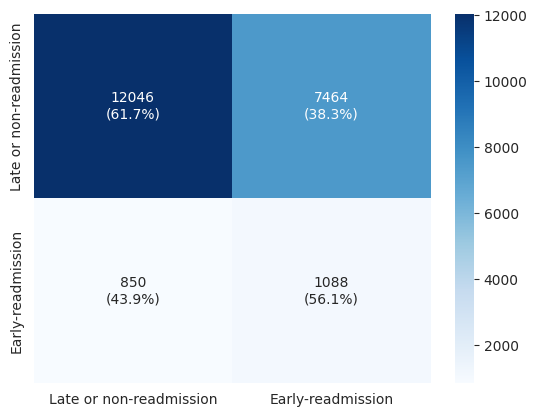

In [27]:
# Visualize confusion matrix with both absolute and percentage values
cm_rus = confusion_matrix(y_test, y_test_pred_rus)
cm_rus_norm = confusion_matrix(y_test, y_test_pred_rus, normalize='true')

annotations_rus = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_rus, cm_rus_norm)
])

sns.heatmap(
    cm_rus,
    annot=annotations_rus,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **4. Optuna Hyper-parameter Tuning | SMOTE**
Hyper-parameter tuning of the model using Optuna, and oversampling with SMOTE.

### 4.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [266]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "hidden_layer_sizes": tuple(
            trial.suggest_int(f"layer_{i}", 32, 128, step=16) for i in range(trial.suggest_int("n_layers", 1, 3))
        ),
        "activation": trial.suggest_categorical("activation", ["tanh", "relu", "logistic"]),
        "solver": trial.suggest_categorical("solver", ["sgd", "adam"]),
        "alpha": trial.suggest_float("alpha", 1e-5, 1e-2, log=True),
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-3, 1e-1, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64]),
        "early_stopping": False,
        "max_iter": 15
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTE(random_state=RANDOM_STATE),
        MLPClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [ ]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

### 4.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [ ]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

In [ ]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

### 4.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_contour(study)

In [ ]:
optuna.visualization.plot_timeline(study)

### 4.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [ ]:
# Fit best model on the training set
best_params = study.best_params

# Get hidden layer sizes
hidden_layer_sizes = tuple(
    best_params[f"layer_{i}"] for i in range(best_params["n_layers"])
)

# Remove hidden layer sizes from best_params
best_params = {key: val for key, val in best_params.items() if not key.startswith(("layer_", "n_layers"))}

pipeline_smote = make_pipeline(
    SMOTE(random_state=RANDOM_STATE),
    MLPClassifier(**best_params, max_iter=200, early_stopping=True, random_state=RANDOM_STATE)
)

pipeline_smote.fit(X_train, y_train)

In [277]:
# Predictions
y_train_pred_smote = pipeline_smote.predict(X_train)
y_test_pred_smote = pipeline_smote.predict(X_test)

In [ ]:
ac_train_smote = accuracy_score(y_train, y_train_pred_smote)
ac_test_smote = accuracy_score(y_test, y_test_pred_smote)

print('Train accuracy: ', ac_train_smote)
print('Test accuracy: ', ac_test_smote)

In [ ]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smote,
    target_names=['Late or non-readmission', 'Early-readmission']
))

In [280]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smote = recall_score(y_test, y_test_pred_smote, average='macro')
precision_smote = precision_score(y_test, y_test_pred_smote, average='macro')
f1_smote = f1_score(y_test, y_test_pred_smote, average='macro')
roc_auc_smote = roc_auc_score(y_test, y_test_pred_smote, average='macro')
accuracy_smote = accuracy_score(y_test, y_test_pred_smote)

In [ ]:
# Visualize confusion matrix with both absolute and percentage values
cm_smote = confusion_matrix(y_test, y_test_pred_smote)
cm_smote_norm = confusion_matrix(y_test, y_test_pred_smote, normalize='true')

annotations_smote = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smote, cm_smote_norm)
])

sns.heatmap(
    cm_smote,
    annot=annotations_smote,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **5. Optuna Hyper-parameter Tuning | SMOTE + Tomek Links**
Hyper-parameter tuning of the model using Optuna, by oversampling with SMOTE and undersampling with Tomek Links.

### 5.1 Objective & study setup
Preparing the objective function with all hyper-parameters, and creating/loading the Optuna study.

In [282]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameter search space
    params = {
        "hidden_layer_sizes": tuple(
            trial.suggest_int(f"layer_{i}", 32, 128, step=16) for i in range(trial.suggest_int("n_layers", 1, 3))
        ),
        "activation": trial.suggest_categorical("activation", ["tanh", "relu", "logistic"]),
        "solver": trial.suggest_categorical("solver", ["sgd", "adam"]),
        "alpha": trial.suggest_float("alpha", 1e-5, 1e-2, log=True),
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-3, 1e-1, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64]),
        "early_stopping": False,
        "max_iter": 15
    }
    
    # Build pipeline
    pipeline = make_pipeline(
        SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
        MLPClassifier(**params, random_state=RANDOM_STATE)
    )
    
    # Define validation folds
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    # Cross validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=SCORING)

    print("Cross validation scores: {}".format(scores))
    print("Average score: {}".format(scores.mean()))

    return scores.mean()

In [ ]:
# Set up study with name and storage
storage = JournalStorage(JournalFileBackend(STUDY_PATH_SMOTE_TOMEK))

study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(constant_liar=True, seed=RANDOM_STATE),
    pruner=optuna.pruners.SuccessiveHalvingPruner()
)

optuna.logging.set_verbosity(optuna.logging.INFO)

### 5.2 Hyper-parameter tuning
**(CAUTION)** <u>Do not run</u>, unless you already need to find the best parameters. If you already have bound the best model configuration, <u>run the section above</u> _(Objective & study setup)_.

In [ ]:
study.optimize(
    objective,
    n_trials=N_TRIALS,
    n_jobs=-1 # Use all available cores
)

In [ ]:
print('Best Trial: {}'.format(study.best_trial.number))
print('Best Parameters: {}'.format(study.best_params))
print('Best Value: {}'.format(study.best_value))

### 5.3 Optuna Visualizations
Visualizing hyper-parameter tuning results obtained by running Optuna.

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_contour(study)

In [ ]:
optuna.visualization.plot_timeline(study)

### 5.4 Fitting Best Model
Fitting the final model using the best hyper-parameters found by Optuna.

In [ ]:
# Fit best model on the training set
best_params = study.best_params

# Get hidden layer sizes
hidden_layer_sizes = tuple(
    best_params[f"layer_{i}"] for i in range(best_params["n_layers"])
)

# Remove hidden layer sizes from best_params
best_params = {key: val for key, val in best_params.items() if not key.startswith(("layer_", "n_layers"))}

pipeline_smotetomek = make_pipeline(
    SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE),
    MLPClassifier(**best_params, max_iter=200, early_stopping=True, random_state=RANDOM_STATE)
)

pipeline_smotetomek.fit(X_train, y_train)

In [293]:
# Predictions
y_train_pred_smotetomek = pipeline_smotetomek.predict(X_train)
y_test_pred_smotetomek = pipeline_smotetomek.predict(X_test)

In [ ]:
ac_train_smotetomek = accuracy_score(y_train, y_train_pred_smotetomek)
ac_test_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

print('Train accuracy: ', ac_train_smotetomek)
print('Test accuracy: ', ac_test_smotetomek)

In [ ]:
# Visualize precision, recall, F1-score
print(classification_report(
    y_test, y_test_pred_smotetomek,
    target_names=['Late or non-readmission', 'Early-readmission']
))

In [296]:
# Compute precision, recall, F1-score, ROC-AUC-score, and accuracy
recall_smotetomek = recall_score(y_test, y_test_pred_smotetomek, average='macro')
precision_smotetomek = precision_score(y_test, y_test_pred_smotetomek, average='macro')
f1_smotetomek = f1_score(y_test, y_test_pred_smotetomek, average='macro')
roc_auc_smotetomek = roc_auc_score(y_test, y_test_pred_smotetomek, average='macro')
accuracy_smotetomek = accuracy_score(y_test, y_test_pred_smotetomek)

In [ ]:
# Visualize confusion matrix with both absolute and percentage values
cm_smotetomek = confusion_matrix(y_test, y_test_pred_smotetomek)
cm_smotetomek_norm = confusion_matrix(y_test, y_test_pred_smotetomek, normalize='true')

annotations_smotetomek = np.array([
    [f"{val}\n({perc:.1%})" for val, perc in zip(row, norm_row)]
    for row, norm_row in zip(cm_smotetomek, cm_smotetomek_norm)
])

sns.heatmap(
    cm_smotetomek,
    annot=annotations_smotetomek,
    cmap='Blues',
    fmt='',
    xticklabels=['Late or non-readmission', 'Early-readmission'],
    yticklabels=['Late or non-readmission', 'Early-readmission']
)

## **6. Results Combined**
Visualizing all results obtained by different sampling methods, on the best respective models.

In [ ]:
# Combine all confusion matrices into a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
cm_list = [cm_none_norm, cm_rus_norm, cm_smote_norm, cm_smotetomek_norm]
annotations = [annotations_none, annotations_rus, annotations_smote, annotations_smotetomek]
labels = ['No Under/Oversampling', 'Random Undersampling', 'SMOTE', 'SMOTE-Tomek']

# Define tick labels
xticklabels = ['Late or non-readmission', 'Early-readmission']
yticklabels = ['Late or non-readmission', 'Early-readmission']

for i, cm in enumerate(cm_list):
    ax=axs[i//2, i%2]
    sns.heatmap(
        cm,
        annot=annotations[i],
        cmap='Blues',
        fmt='',
        vmin=0, vmax=1,
        ax=axs[i//2, i%2],
        xticklabels=['Late or non-readmission', 'Early-readmission'],
        yticklabels=['Late or non-readmission', 'Early-readmission']
    )
    ax.set_title(labels[i])
    
    # Hide x-tick labels for the top row
    if i < 2:
        ax.set_xticklabels([])
    # Hide y-tick labels for the right column
    if i % 2 == 1:
        ax.set_yticklabels([])

plt.tight_layout()
plt.show()

Visualizing the scores for each method.

In [ ]:
# Combine all metrics into a single DataFrame
data = {
    'Recall': [recall_none, recall_rus, recall_smote, recall_smotetomek],
    'Precision': [precision_none, precision_rus, precision_smote, precision_smotetomek],
    'F1-score': [f1_none, f1_rus, f1_smote, f1_smotetomek],
    'ROC-AUC': [roc_auc_none, roc_auc_rus, roc_auc_smote, roc_auc_smotetomek],
    'Accuracy': [accuracy_none, accuracy_rus, accuracy_smote, accuracy_smotetomek]
}

metrics_df = pd.DataFrame(data, index=labels)
metrics_df

In [ ]:
# Visualize all metrics in a bar plot, by coloring each method differently, using SeaBorn barplot and adding grids
sns.set_palette('viridis')
metrics_df.plot(kind='bar', figsize=(10, 4))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()